# <font size="8">Welcome to sedcreator! </font>

<font size="4">`sedcreator` is a developing package and this notebook works for version 0.6.10</font>


<font size="4">Before we start make sure you have `sedcreator` installed. It can be installed by simply typing:</font>

-------
```pip install sedcreator==0.6.10```
-------

<font size="4"> In some distributions you may need to type `pip3` instead, so it would be:</font>
    

```pip3 install sedcreator==0.6.10```
-------

-------

<font size="4">`sedcreator` is composed of two main classes `SedFluxer` and `SedFitter` to construct and fit **Spectral Energy Distributions (SEDs)**. In this notebook we will walk you through the main features of `SedFitter`. Please check out the other examples for more.
    
*The main purpose of `SedFitter` is to fit measured fluxes from astronomical sources. It uses the [Zhang & Tan (2018)](https://ui.adsabs.harvard.edu/abs/2018ApJ...853...18Z/abstract) model grid. It includes a number of functions to retrieve the best models, plot SEDs and more.*

If you make use of sedcreator in your work or as a dependency of other package, please include the following citation/acknowledgment:</font> https://sedcreator.readthedocs.io/en/latest/citation.html

## The full documentation can be accessed in this link: https://sedcreator.readthedocs.io/en/latest/index.html

---
---

# My first SED fit

As always we start off by importing the packages. Even though in this example we will only make use of `SedFitter` and `ModelPlotter`, we also import `SedFluxer`  for completeness

In [1]:
from sedcreator import SedFluxer, SedFitter, ModelPlotter
import numpy as np

Now we need some data to work with. We will use the fluxes calculated in the [SedFluxer_example.ipynb](https://github.com/fedriani/sedcreator/blob/main/examples/SedFluxer_example.ipynb). The workflow is as follows:

1. Define the 5 inputs arrays that the `SedFitter` class needs. These are:
    - Wavelength array
    - Flux array
    - Error Flux array
    - Upper limits array
    - Filter Names array
2. Initialise the `SedFitter` class
3. Define distance (dist) to the source and maximum visual extinction (AV_max) value allow for the fit.
4. With the above defined, we can use the function `sed_fit()` 

You may be familiar with the first three arrays to be defined in step 1, but we also need to define what fluxes are upper limits and the names of the filters so the model can be convolved by the filter response of the specific instrument used.

In the Zhang and Tan (ZT) model grid, all fluxes below 8µm are considered upper limits as these may be affected by Polycyclic Aromatic Hydrocarbon (PAH) emission and thermal emission from very small grains that are transiently heated by single photons. Neither of these effects are included in the ZT radiative transfer models. Therefore, we treat the data at these wavelengths as upper limit constraints on the models

You may not be familiar with the filter names of the model, but you can run the following to find it out (see examples to learn how to add your own filters)

In [2]:
SedFitter().print_default_filters

filter wavelength   instrument  
------ ---------- --------------
    2J        1.2          2MASS
    2H        1.6          2MASS
    2K        2.2          2MASS
    I1        3.6   Spitzer_IRAC
    I2        4.5   Spitzer_IRAC
    I3        5.6   Spitzer_IRAC
    I4        8.0   Spitzer_IRAC
    M1       24.0   Spitzer_MIPS
    M2       70.0   Spitzer_MIPS
    M3      160.0   Spitzer_MIPS
    F1        5.4  SOFIA_FORCAST
    F2        6.4  SOFIA_FORCAST
    F3        6.6  SOFIA_FORCAST
    F4        7.7  SOFIA_FORCAST
    F5        8.6  SOFIA_FORCAST
    F6       11.1  SOFIA_FORCAST
    F7       11.3  SOFIA_FORCAST
    F8       19.2  SOFIA_FORCAST
    F9       24.2  SOFIA_FORCAST
    L1       31.5  SOFIA_FORCAST
    L2       33.6  SOFIA_FORCAST
    L3       34.8  SOFIA_FORCAST
    L4       37.1  SOFIA_FORCAST
    P1       70.0  Herschel_PACS
    P2      100.0  Herschel_PACS
    P3      160.0  Herschel_PACS
    P4      250.0 Herschel_SPIRE
    P5      350.0 Herschel_SPIRE
    P6    

In [3]:
#1)
AFGL2591_ALL_lambda = np.array([3.6,4.5,5.8,8.0,#Spitzer wavelengths
                                19.2,31.5,37.1,#SOFIA wavelengths
                                70.0,160.0,250.0,350.0,500.0])#Herschel wavelengths

AFGL2591_ALL_flux_bkg = np.array([74.4515954 ,173.42437309,342.88313519,308.60635702,#Spitzer fluxes
                                  681.70349254,2437.73731863, 3196.31862855,#SOFIA fluxes
                                  4445.46206558,2172.17591409,535.94271553,151.55797272,25.49940585])#Herschel fluxes

AFGL2591_ALL_error = np.array([0.1, 0.1, 0.1, 0.1,#Spitzer fluxes error
                               0.1,0.1, 0.1,#SOFIA fluxes error
                               0.1, 0.11243873, 0.23226553,0.33236597,0.76754935])#Herschel fluxes error

AFGL2591_ALL_upp_lim = np.array([1,1,1,1,#Spitzer fluxes are upper limits
                                 0,0,0,
                                 0,0,0,0,0],
                                dtype=bool)

AFGL2591_ALL_filters = np.array(['I1','I2','I3','I4',#Spitzer filter names
                                 'F8','L1','L4',#SOFIA filter names
                                 'P1','P3','P4','P5','P6'])#Herschel filter names

Once the 5 arrays have been defined we can initiate the `SedFitter` class also defining an extinction law (by default is kmh that refers the [Kim, Martin Hendry 1994](https://ui.adsabs.harvard.edu/abs/1994ApJ...422..164K/abstract)) to as follows:

In [4]:
#2)
AFGL2591_fitter = SedFitter(extc_law='kmh',
                            lambda_array=AFGL2591_ALL_lambda,
                            flux_array=AFGL2591_ALL_flux_bkg,
                            err_flux_array=AFGL2591_ALL_error,
                            upper_limit_array=AFGL2591_ALL_upp_lim,
                            filter_array=AFGL2591_ALL_filters)

Now we can call the function `sed_fit()` to fit our measurements. But first we need to also define the distance to the source and the maximum visual extinction that you want to allow the fit (it goes from 0 to AV_max). Finally we can also set the method ('minimize', 'idl','grid_search') we want to use. We highly recommend to use 'minimize' as is the latest version with improvement with respect to the 'idl' method. However, we kept the 'idl' method to be able to reproduce previous studies that used this method.

The fit should take around a minute, but there is a progress bar in case you want to see the progress

In [5]:
#3)
AFGL2591_dist = 3300.0 #pc
AV_max = 1000 #mag

#4)

AFGL2591_sed_fit = AFGL2591_fitter.sed_fit(dist=AFGL2591_dist,AV_max=AV_max,method='minimize')

  0%|          | 0/8640 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.7/site-packages/sedcreator/__init__.py:1446: RuntimeWarning: divide by zero encountered in log10
  flux_model_Jy_log=np.log10(flux_model_Jy,dtype=np.float64)
100%|██████████| 8640/8640 [00:56<00:00, 151.73it/s]


Congrats! your fit is done. Let's now retrieve the best models

## Retrieving the SED results

AFGL2591_sed_fit is another class from which we can retrieve the SED results table based on the models keys. In short, the model grid has three main physical parameters core mass (mcore), mass surface density (sigma), and mass of the star (mstar), which account for a total of 432 models. For each of these models there are 20 viewing angles (theta_view) which makes a total of 8640 models. Running the following you get access to them. For more details see the documentation and the papers.

In [6]:
AFGL2591_results_3p = AFGL2591_sed_fit.get_model_info(keys=['mcore','sigma','mstar'],
                                                      tablename=None)

AFGL2591_results_4p = AFGL2591_sed_fit.get_model_info(keys=['mcore','sigma','mstar','theta_view'],
                                                      tablename=None) 

The tables are ordered by chi square and are astropy tables. Let's see how one them looks

In [7]:
AFGL2591_results_3p

SED_number,chisq,chisq_nonlim,mcore,sigma,mstar,theta_view,dist,av,rcore,massenv,theta_w_esc,rstar,lstar,tstar,mdisk,rdisk,mdotd,lbol,lbol_iso,lbol_av,t_now
,,,solMass,g / cm2,solMass,deg,pc,mag,pc,solMass,deg,solRad,solLum,K,solMass,AU,solMass / yr,solLum,solLum,solLum,yr
str11,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
11_04_09_03,2.38595,3.57893,200.0,3.16,32.0,28.95502,3300.0,89.02856,0.0585424,140.1301,25.4792,12.0413,341353.0,40226.9,10.66667,65.7713,1.69493e-03,4.60332e+05,5.07652e+05,1.83717e+05,3.50977e+04
15_02_09_01,2.47282,3.29709,480.0,0.316,32.0,12.83857,3300.0,77.76311,0.286798,405.7099,22.2813,7.59469,153623.0,41486.9,10.66667,177.947,3.85348e-04,1.99889e+05,1.26735e+06,1.94905e+05,1.58093e+05
11_04_08_02,2.48087,3.72130,200.0,3.16,24.0,22.33165,3300.0,83.30339,0.0585424,155.5136,19.9721,21.2857,265935.0,28425.1,8.0,52.8715,1.51740e-03,3.08760e+05,8.42750e+05,2.06488e+05,3.01545e+04
12_04_10_04,2.50441,3.75662,240.0,3.16,48.0,34.41151,3300.0,108.31035,0.06413,138.067,33.1107,10.796,500546.0,46749.9,16.0,93.8989,2.08252e-03,7.48849e+05,1.10505e+06,1.98393e+05,4.25262e+04
10_04_08_03,2.53444,3.80166,160.0,3.16,24.0,28.95502,3300.0,50.77570,0.0523619,114.5666,22.8606,18.3313,249881.0,30157.0,8.0,55.357,1.40827e-03,2.96474e+05,2.56484e+05,1.57035e+05,3.19683e+04
15_02_10_03,2.62147,3.93220,480.0,0.316,48.0,28.95502,3300.0,88.03754,0.286798,351.9404,29.8906,9.54956,349047.0,45423.5,16.0,242.849,4.46186e-04,4.12485e+05,1.15592e+06,2.03665e+05,1.95999e+05
15_02_11_04,3.04770,4.57156,480.0,0.316,64.0,34.41151,3300.0,108.46514,0.286798,304.1984,36.8393,11.3662,600196.0,47677.8,21.33333,310.318,4.81944e-04,6.76228e+05,1.83720e+06,2.06427e+05,2.29972e+05
13_03_08_02,3.20373,4.80560,320.0,1.0,24.0,22.33165,3300.0,19.11416,0.131636,269.2532,19.0786,7.20169,120919.0,40128.9,8.0,88.5063,7.31241e-04,1.88918e+05,2.96897e+05,2.00924e+05,6.38949e+04


## Plotting the SED results

In order to make the plotting the results nice and easy, we have created the class `ModelPlotter`. To initialise it, we need the results from the SED fit, in order to retain the input information there.

For example, we can plot the best five SED models from our results as follows:

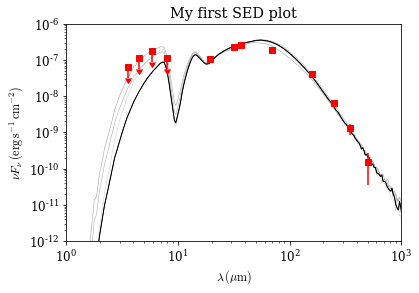

In [8]:
AFGL2591_md = ModelPlotter(AFGL2591_sed_fit)
AFGL2591_md.plot_multiple_seds(models=AFGL2591_results_3p[0:5],
                               figsize=(6,4),
                               xlim=[1e0,1e3],ylim=[1e-12,1e-6],
                               title='My first SED plot',
                               marker='rs',cmap='gray',colorbar=False,
                               figname=None)

Or all the models satisfying a condition, for example all models with chi square below 50.

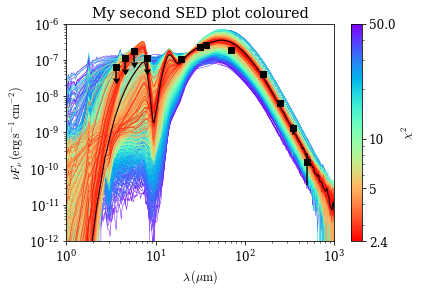

In [9]:
AFGL2591_md.plot_multiple_seds(models=AFGL2591_results_4p[AFGL2591_results_4p['chisq']<50.0],
                               figsize=(6,4),
                               xlim=[1e0,1e3],ylim=[1e-12,1e-6],
                               title='My second SED plot coloured',
                               marker='ks',cmap='rainbow_r',colorbar=True,
                               figname=None)

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


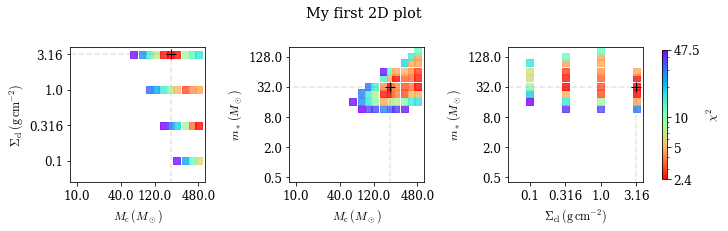

In [10]:
AFGL2591_md.plot2d(models=AFGL2591_results_3p[AFGL2591_results_3p['chisq']<=50.0],
                   figsize=(10, 5),
                   marker='s',
                   marker_size=50,
                   cmap='rainbow_r',
                   title='My first 2D plot',
                   figname=None)

<font size="4">The above example assumes that you have measured somehow the fluxes. You can use `SedFluxer` for that ( [see example notebook](https://github.com/fedriani/sedcreator/blob/main/examples/SedFluxer_example.ipynb) )

</font>

---
---
<font size="4">Author: R. Fedriani (Chalmers University of Technology)

Last update: 7 April 2022</font>

---